In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Flatten, Concatenate, Input, Dropout, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')


import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

# [캐글 tweet-sentiment-data](https://www.kaggle.com/maxjon/complete-tweet-sentiment-extraction-data/)를 이용한 감성분석 


## 1. Preprocessing

In [ ]:
# 데이터 로드---------------------------------------
tweet_data = pd.read_csv('./data/tweet_dataset.csv')
# tweet_data.head()
tweet = tweet_data[['text', 'sentiment']]

# print(tweet.sentiment.unique(), '→', tweet.sentiment.nunique())  
# print(tweet.isna().sum()) # text에 66개의 null data 있음
print("# loaded data")



# 데이터 전처리-------------------------------------
tweet['text'] = tweet['text'].apply(lambda x: str(x).lower())
tweet['text'] = tweet['text'].str.replace(r'[^\w]', ' ')
tweet['text'] = tweet['text'].replace('', np.nan)

y_cate_list = pd.factorize(tweet['sentiment'])[1]
tweet['senti_label'] = pd.factorize(tweet['sentiment'])[0]

tweet = tweet.dropna(how='any', axis=0)
tweet = tweet[tweet['text'] != 'nan']
print('# preprocessing done')


# split---------------------------------------------
txt_train, txt_test, y_train, y_test = train_test_split(tweet['text'], tweet['senti_label'], test_size=0.2, shuffle=True, random_state=1234)
print('# split done')

# y OHE-------------------------------------
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# 토큰화--------------------------------------------
stopwords = ['a', 'an', 'in', 'on', 'and', 'for', 'the', 's', 'to', 'is', 'with', 'of', 'you',
             'at', 'that', 'what', 'this', 'be', 'your', 't', 'it', 'from', 'are', 'about', 'as', 'i', 'my']

X_train = []
for stc in txt_train:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_train.append(token)

X_test = []
for stc in txt_test:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_test.append(token)

print('# tokenization done')

# loaded data
# preprocessing done
# split done
# tokenization done


전체 단어 개수: 29043
빈도수 3이상인 단어 개수: 7772
빈도수 4이상인 단어 개수: 6012


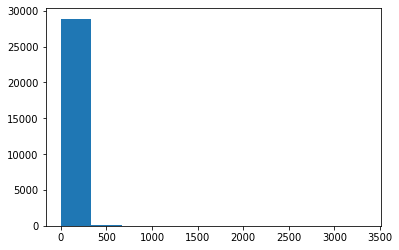

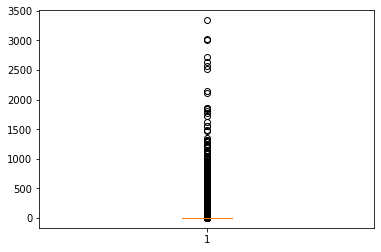

In [ ]:
# 정수 인코딩 이전 과정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# > 단어 개수 확인
print("전체 단어 개수:", len(tokenizer.word_index))
print("빈도수 3이상인 단어 개수:", len([token for token, count in tokenizer.word_counts.items() if count >= 3]))
print("빈도수 4이상인 단어 개수:", len([token for token, count in tokenizer.word_counts.items() if count >= 4]))
plt.subplots()
plt.hist(list(tokenizer.word_counts.values()))
plt.subplots()
plt.boxplot(list(tokenizer.word_counts.values()));

In [ ]:
# 정수 인코딩
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print('# int_encoding done')

# int_encoding done


In [ ]:
# padding
X_train = pad_sequences(X_train, padding='post', maxlen=30)
X_test = pad_sequences(X_test, padding='post', maxlen=30)
print('# padding done')

# padding done


## 2. Training

In [ ]:
print(X_train.shape, X_test.shape)

(31947, 30) (7987, 30)


#### - LSTM

In [ ]:
# model = Sequential()

# model.add(Embedding(7000, 256, input_length=len(X_train[0])))
# model.add(LSTM(256))
# model.add(Dense(y_train.shape[1], activation='softmax'))

In [ ]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
# # overfitting 조짐이 보여서 lstm layer 수 변경
# # 128 -> 32 -> 256 : 32가 제일 낫긴 한데 구리긴 마찬가지(val_acc : 0.3대가 제일 높음)

#### - CNN(LSTM의 성능이 나빠서 solution 참고하여 CNN 사용 → 성능은 LSTM과 비슷하게 좋지 않음)

In [ ]:
# 함수형 케라스
inputs = Input(shape=(30,))
embed = Embedding(7000, 30)(inputs)
drop = Dropout(0.3)(embed)


# 모델 합성
concat_layers = []

conv = Conv1D(30 , 3, padding='same', activation='relu')(drop)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

conv = Conv1D(30, 4, padding='same', activation='relu')(drop)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

conv = Conv1D(30, 5, padding='same', activation='relu')(drop)
pool = GlobalMaxPooling1D()(conv)
flat = Flatten()(pool)
concat_layers.append(flat)

concat = Concatenate()(concat_layers)
relu = Dense(64, activation='relu')(concat)
drop = Dropout(0.5)(relu)

outputs = Dense(y_train[0].shape[0], activation='softmax')(drop)

model = Model(inputs, outputs)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=100)

Epoch 1/100
500/500 [==============================] - 4s 7ms/step - loss: 2.1803 - accuracy: 0.2361 - val_loss: 2.0924 - val_accuracy: 0.2707
Epoch 2/100
500/500 [==============================] - 3s 7ms/step - loss: 2.0212 - accuracy: 0.3082 - val_loss: 1.9732 - val_accuracy: 0.3268
Epoch 3/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9476 - accuracy: 0.3427 - val_loss: 1.9303 - val_accuracy: 0.3411
Epoch 4/100
500/500 [==============================] - 3s 7ms/step - loss: 1.9057 - accuracy: 0.3555 - val_loss: 1.9061 - val_accuracy: 0.3523
Epoch 5/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8729 - accuracy: 0.3702 - val_loss: 1.8970 - val_accuracy: 0.3528
Epoch 6/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8499 - accuracy: 0.3804 - val_loss: 1.9038 - val_accuracy: 0.3489
Epoch 7/100
500/500 [==============================] - 3s 7ms/step - loss: 1.8279 - accuracy: 0.3881 - val_loss: 1.9024 - val_accuracy: 0.3524

---

# 모델 수정해서 성능 높이기

- nltk를 이용해서 토큰화하기
- 그동안 배운 RNN, LSTM, CNN을 이용하여 레이어를 다양하게 쌓아보기
- 하이퍼파라미터 다양하게 바꿔보기
- 앙상블하기


## 1. SimpleRNN 
- loss: 1.8556 - accuracy: 0.3823 - val_loss: 2.1245 - val_accuracy: 0.2719

In [ ]:
from tensorflow.keras.layers import SimpleRNN

vocab_size = len(tokenizer.word_index) + 1

Inputs = Input(shape=(30,))
embed = Embedding(vocab_size, 50)(Inputs)
rnn_outputs = SimpleRNN(50)(embed) # 50 = dimensionality of the output space
Outputs = Dense(y_train[0].shape[0], activation='softmax')(rnn_outputs)

mod_rnn = Model(Inputs, Outputs)

In [ ]:
mod_rnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
mod_rnn.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=50)

Epoch 1/50
500/500 [==============================] - 15s 30ms/step - loss: 2.1118 - accuracy: 0.2537 - val_loss: 2.1045 - val_accuracy: 0.2661
Epoch 2/50
500/500 [==============================] - 15s 30ms/step - loss: 1.9870 - accuracy: 0.3215 - val_loss: 2.1580 - val_accuracy: 0.2517
Epoch 3/50
500/500 [==============================] - 15s 30ms/step - loss: 1.8556 - accuracy: 0.3823 - val_loss: 2.1245 - val_accuracy: 0.2719
Epoch 4/50
500/500 [==============================] - 15s 29ms/step - loss: 1.7304 - accuracy: 0.4312 - val_loss: 2.2374 - val_accuracy: 0.2499
Epoch 5/50
500/500 [==============================] - 14s 29ms/step - loss: 1.6139 - accuracy: 0.4750 - val_loss: 2.3350 - val_accuracy: 0.2514
Epoch 6/50
500/500 [==============================] - 14s 29ms/step - loss: 1.5032 - accuracy: 0.5176 - val_loss: 2.3210 - val_accuracy: 0.2583
Epoch 7/50
500/500 [==============================] - 15s 29ms/step - loss: 1.4034 - accuracy: 0.5567 - val_loss: 2.5739 - val_accuracy:

## 3. Prediction

In [ ]:
stc = input() # 영어
stc = stc.lower()

import re
stc = re.sub('[^\w]', ' ', stc)
token_stc = stc.split()
encode_stc = tokenizer.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=32)

score = model.predict(pad_stc)

print(y_cate_list[score.argmax()], score[0, score.argmax()])

i know  i was listenin to bad habit earlier and i started freakin at his part
worry 0.17115688
